# Titanic

# Libraries

In [1]:
import pandas as pd

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np

# Data

In [2]:
df_train = pd.read_csv('./datasets/train.csv')
df_test = pd.read_csv('./datasets/test.csv')
df_submit = pd.read_csv('./datasets/gender_submission.csv')

In [3]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# NaN

In [5]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Cat and Num features

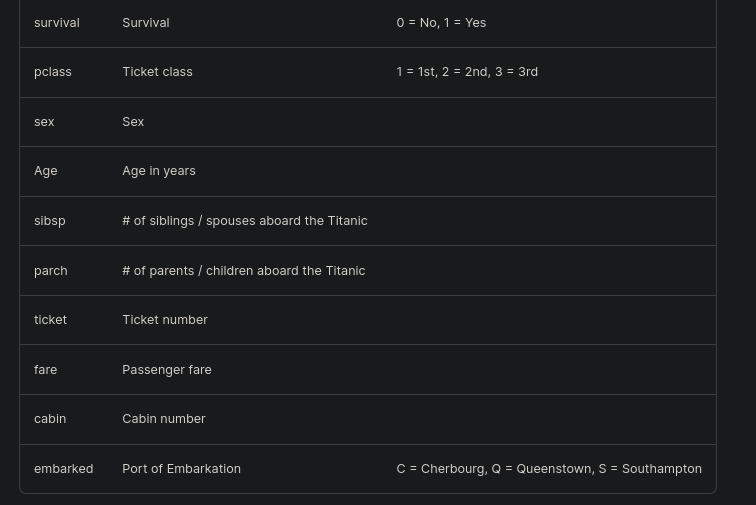

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Drop columns

In [7]:
def drop_cols(df):
    df.drop(columns=['PassengerId', 'Name', "Ticket", "Cabin"], axis=0, inplace=True)

In [8]:
drop_cols(df_train)
drop_cols(df_test)

In [9]:
def get_num(df):
    df['SibSp'] = df['SibSp'].astype(str)
    df['Parch'] = df['Parch'].astype(str)
    df['Pclass'] = df['Pclass'].astype(str)
    return df.select_dtypes(include=[int, float])

def get_cat(df):
    df['SibSp'] = df['SibSp'].astype(str)
    df['Parch'] = df['Parch'].astype(str)
    df['Pclass'] = df['Pclass'].astype(str)
    return df.select_dtypes(include=[object]).astype(str)

In [10]:
df_train_num = get_num(df_train)
df_test_num = get_num(df_test)

df_train_cat = get_cat(df_train)
df_test_cat = get_cat(df_test)

array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >]], dtype=object)

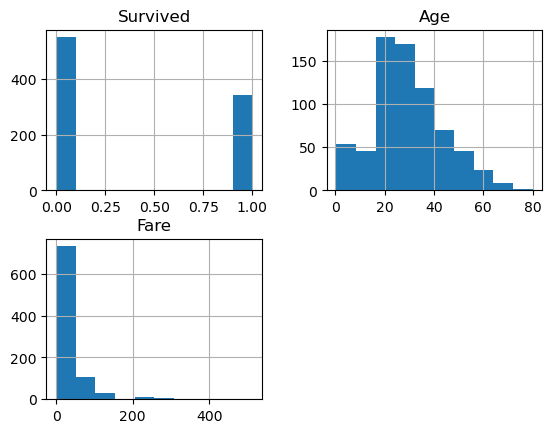

In [11]:
df_train_num.hist()

In [12]:
df_train_cat

,Pclass,Sex,SibSp,Parch,Embarked
0,3,male,1,0,S
1,1,female,1,0,C
2,3,female,0,0,S
3,1,female,1,0,S
4,3,male,0,0,S
...,...,...,...,...,...
886,2,male,0,0,S
887,1,female,0,0,S
888,3,female,1,2,S
889,1,male,0,0,C


## Impute NaNs

In [13]:
imp = SimpleImputer(strategy="median")

In [14]:
df_train_num = pd.DataFrame(imp.fit_transform(df_train_num), columns=df_train_num.columns)
df_test_num = pd.DataFrame(imp.fit_transform(df_test_num), columns=df_test_num.columns)

In [15]:
# df_train_cat['Embarked'].value_counts()
df_train_cat['Embarked'].fillna('Q', inplace=True)

In [16]:
# df_train_cat.isna().sum()
df_test_cat.isna().sum()

Pclass      0
Sex         0
SibSp       0
Parch       0
Embarked    0
dtype: int64

In [17]:
# print(df_test_cat['Embarked'].value_counts())
df_test_cat['Embarked'].fillna('Q', inplace=True)

# New Features

In [18]:
df_train_num.corr()['Survived']

Survived    1.000000
Age        -0.064910
Fare        0.257307
Name: Survived, dtype: float64

In [19]:
df_train_num['fare_per_age'] = df_train_num['Fare'] / df_train_num['Age']
df_test_num['fare_per_age'] = df_test_num['Fare'] / df_test_num['Age']

In [20]:
df_train_num.corr()['Survived']

Survived        1.000000
Age            -0.064910
Fare            0.257307
fare_per_age    0.136219
Name: Survived, dtype: float64

# Get dummies

In [21]:
df_train_catd = pd.get_dummies(df_train_cat)
df_test_catd = pd.get_dummies(df_test_cat)

In [22]:
df_test_catd.drop(columns=['Parch_9'], inplace=True)
df_train_catd.drop(columns=['Embarked_nan'], inplace=True)

## Concat

In [50]:
df_train = pd.concat([df_train_num, df_train_catd.astype(str)], axis=1)
df_train_ = pd.concat([df_train_num, df_train_cat.astype(str)], axis=1)
df_test = pd.concat([df_test_num, df_test_catd.astype(str)], axis=1)
df_test_ = pd.concat([df_test_num, df_test_cat.astype(str)], axis=1)

In [51]:
df_train_

,Survived,Age,Fare,fare_per_age,Pclass,Sex,SibSp,Parch,Embarked
0,0.0,22.0,7.2500,0.329545,3,male,1,0,S
1,1.0,38.0,71.2833,1.875876,1,female,1,0,C
2,1.0,26.0,7.9250,0.304808,3,female,0,0,S
3,1.0,35.0,53.1000,1.517143,1,female,1,0,S
4,0.0,35.0,8.0500,0.230000,3,male,0,0,S
...,...,...,...,...,...,...,...,...,...
886,0.0,27.0,13.0000,0.481481,2,male,0,0,S
887,1.0,19.0,30.0000,1.578947,1,female,0,0,S
888,0.0,28.0,23.4500,0.837500,3,female,1,2,S
889,1.0,26.0,30.0000,1.153846,1,male,0,0,C


In [52]:
df_test_

,Age,Fare,fare_per_age,Pclass,Sex,SibSp,Parch,Embarked
0,34.5,7.8292,0.226933,3,male,0,0,Q
1,47.0,7.0000,0.148936,3,female,1,0,S
2,62.0,9.6875,0.156250,2,male,0,0,Q
3,27.0,8.6625,0.320833,3,male,0,0,S
4,22.0,12.2875,0.558523,3,female,1,1,S
...,...,...,...,...,...,...,...,...
413,27.0,8.0500,0.298148,3,male,0,0,S
414,39.0,108.9000,2.792308,1,female,0,0,C
415,38.5,7.2500,0.188312,3,male,0,0,S
416,27.0,8.0500,0.298148,3,male,0,0,S


# ML

LogisticRegression

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns=["Survived"]), df_train['Survived'])

In [27]:
cls = LogisticRegression(penalty="elasticnet", n_jobs=-1)

In [28]:
def objective(trial):
    class_weight = dict()
    class_weight[0] = trial.suggest_float("0", 1e-1, 4)
    class_weight[1] = trial.suggest_float("1", 1e-1, 3)
    params = {
        "max_iter": 100_000_000,
        "penalty": "elasticnet",
        "n_jobs" : -1,
        "C": trial.suggest_float("C", 1e-1, 10),
        "class_weight": class_weight,
        "solver": trial.suggest_categorical("solver", ["saga"]),
        "l1_ratio": trial.suggest_float('l1_ratio', 0, 1),
    }
    cls = LogisticRegression(**params)
    cls.fit(X_train, y_train)
    return f1_score(y_test, cls.predict(X_test))

In [29]:
study = optuna.create_study(study_name="log", direction="maximize")
# study.optimize(objective, n_trials=10, n_jobs=-1)

[I 2023-05-11 12:18:43,258] A new study created in memory with name: log


In [30]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  0
Best trial:


ValueError: No trials are completed yet.

In [ ]:
trial.params['class_weight'] = {0: trial.params['0'], 1: trial.params['1']}
trial.params.pop('0', None)
trial.params.pop('1', None)

2.488974646141833

In [ ]:
cls = LogisticRegression(**trial.params)
cls.fit(df_train.drop(columns=["Survived"]), df_train['Survived'])

/home/artem/micromamba/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/artem/micromamba/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=4.171032625380737,
                   class_weight={0: 0.6189345796910009, 1: 2.488974646141833},
                   l1_ratio=0.34787610394599944, solver='saga')

In [ ]:
X_test = df_test

In [ ]:
y_pred = cls.predict(X_test)

In [ ]:
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

# Catboost

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_train_.drop(columns=['Survived']), df_train_['Survived'])

In [86]:
def objective(trial):
    categorical_features_indices = np.where(X_train.dtypes != float)[0]
    class_weights = dict()
    class_weights[0.0] = trial.suggest_float("0", 0.0, 2)
    class_weights[1.0] = trial.suggest_float("1", 2, 5.0)
    param = {
        "iterations": trial.suggest_int("iterations", 100, 5_000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, .4),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1e-7, 100.0),
        "border_count": trial.suggest_int("border_count", 1, 200),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0),
        "max_ctr_complexity": trial.suggest_int("max_ctr_complexity", 1, 5),
        "objective": trial.suggest_categorical("objective", ["Logloss", "MultiClassOneVsAll"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 3, 8),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        # "used_ram_limit": "3gb",
        "class_weights": class_weights,
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_cls = CatBoostClassifier(**param)

    cat_cls.fit(X_train, y_train, eval_set=[(X_test, y_test)],verbose=0, early_stopping_rounds=50, cat_features=categorical_features_indices)

    preds = cat_cls.predict(X_test)
    ac = accuracy_score(y_test, preds)
    return ac

In [87]:
sampler = TPESampler(seed=37)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2023-05-11 12:38:55,774] A new study created in memory with name: catboost
[I 2023-05-11 12:38:58,782] Trial 1 finished with value: 0.8026905829596412 and parameters: {'0': 1.6948962463680446, '1': 3.9587697092297462, 'iterations': 5000, 'learning_rate': 0.27710673911048994, 'l2_leaf_reg': 40, 'border_count': 64, 'random_strength': 7.681798392843949, 'max_ctr_complexity': 1, 'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.016756712777324767, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 43}. Best is trial 1 with value: 0.8026905829596412.
[I 2023-05-11 12:38:58,985] Trial 0 finished with value: 0.8026905829596412 and parameters: {'0': 1.5497435993433157, '1': 2.1550385215121777, 'iterations': 4900, 'learning_rate': 0.20944271613419935, 'l2_leaf_reg': 28, 'border_count': 39, 'random_strength': 3.410068184439061, 'max_ctr_complexity': 2, 'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.035506964900295146, 'depth': 8, 'b

In [88]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.8654708520179372
  Params: 
    0: 1.9739495603202004
    1: 2.1149586521802246
    iterations: 2500
    learning_rate: 0.1981457070140028
    l2_leaf_reg: 87
    border_count: 40
    random_strength: 0.17595380953033915
    max_ctr_complexity: 5
    objective: Logloss
    colsample_bylevel: 0.09695427388055664
    depth: 8
    boosting_type: Plain
    bootstrap_type: Bernoulli
    od_type: IncToDec
    od_wait: 16
    subsample: 0.1227461954798138


In [89]:
trial.params['class_weights'] = {0: trial.params['0'], 1: trial.params['1']}
trial.params['iterations'] = 10_000
trial.params.pop('0', None)
trial.params.pop('1', None)

2.1149586521802246

In [90]:
cat = CatBoostClassifier(**trial.params)
cat.fit(df_train_.drop(columns=["Survived"]), df_train_['Survived'], cat_features=np.where(X_train.dtypes != float)[0])

0:	learn: 0.6859647	total: 2.52ms	remaining: 25.2s
1:	learn: 0.6813588	total: 4.31ms	remaining: 21.5s
2:	learn: 0.6784074	total: 7.45ms	remaining: 24.8s
3:	learn: 0.6703315	total: 10ms	remaining: 25.1s
4:	learn: 0.6133513	total: 20.7ms	remaining: 41.4s
5:	learn: 0.6123999	total: 26.8ms	remaining: 44.6s
6:	learn: 0.6108049	total: 29.4ms	remaining: 42s
7:	learn: 0.5724123	total: 35.6ms	remaining: 44.5s
8:	learn: 0.5712009	total: 39.6ms	remaining: 44s
9:	learn: 0.5711574	total: 42.9ms	remaining: 42.9s
10:	learn: 0.5711280	total: 46ms	remaining: 41.7s
11:	learn: 0.5711101	total: 47.3ms	remaining: 39.4s
12:	learn: 0.5706435	total: 49.7ms	remaining: 38.1s
13:	learn: 0.5440989	total: 51.5ms	remaining: 36.7s
14:	learn: 0.5440971	total: 54ms	remaining: 36s
15:	learn: 0.5440959	total: 56.3ms	remaining: 35.1s
16:	learn: 0.5309884	total: 60ms	remaining: 35.2s
17:	learn: 0.5309884	total: 61.7ms	remaining: 34.2s
18:	learn: 0.5309883	total: 63.3ms	remaining: 33.2s
19:	learn: 0.5309882	total: 65ms	rem

In [91]:
f1_score(y_test, cat.predict(X_test))

0.8764044943820225

In [95]:
y_pred = cat.predict(df_test_)

In [96]:
y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,

# Ans

In [94]:
df_submit['Survived'] = list(map(int, y_pred))
df_submit.to_csv('submission.csv', index=False)